# CIFAR-100 画像データを用いた機械学習と画像認識の実験

![cifar100)](https://user-images.githubusercontent.com/5820803/93660941-d8ee0900-fa8e-11ea-9d81-4c17f52c128e.png)

　　　　　　図１　CIAR-100 画像の例

 CIFAR-100は画像認識の研究用画像データセットです。詳しくは[こちら](https://www.atmarkit.co.jp/ait/articles/2006/15/news036.html)

- 5万枚の訓練データ用（画像とラベル）   (train)
- 1万枚のテストデータ用（画像とラベル） (test)  
 
合計6万枚で構成されています。

  これらの画像は動物や乗り物など100カテゴリの被写体のどれかが写った写真です.
 それぞれの被写体の画像は同じ枚数存在します。つまり、訓練データは1種類500枚ずつ、テストデータは100枚ずつとなっています。


１枚の画像は

- 幅32×高さ32ピクセル
- 24bit RGBフルカラー画像
- RGBそれぞれ256階調

です。１枚当たり、３×32×32＝3072バイトのサイズです。

このデータを使って、各種識別手法による画像認識の実験を行います。

---

<font size=2 color=darkgreen>識別と学習は表裏一体です。識別はそれに先立って学習が必要です。以下のプログラム中に、**fit** という関数が現れますが、fit とは学習の実行を意味します。</font>




## 準備

<img width="410" alt="ファイル一覧" src="https://user-images.githubusercontent.com/5820803/93660045-0d10fc00-fa86-11ea-883e-a1d75d54e8b2.png">

配布された **taxonomy.txt** をアップロードしておく必要があります．

1. 左のエリアが閉じている場合は，フォルダアイコンをクリックして開く
2. 「ファイル」をクリック．アイコンメニューが出るまで少し待つ．
3. 左端のアイコン、**↑** をクリックし，**taxonomy.txt** をアップロード    
　あるいは、ドラッグ＆ドロップでもアップロードできます。



# CIFER-100画像データの読み込み

In [ ]:
# このセルは Google Colaboratory で実行している場合のみ有効です．
!curl -O https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar zxvf cifar-100-python.tar.gz
!mv cifar-100-python/* .
!rm cifar-100-python.tar.gz meta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161M  100  161M    0     0  89.8M      0  0:00:01  0:00:01 --:--:-- 89.8M
cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


上のプログラムを実行すると、ファイル一覧に、
- train 訓練用画像を１つのファイルにまとめたデータファイル
- test 検証用画像を１つのファイルにまとめたデータファイル  

が現れます。このファイルは全画像を1ファイルにまとめたものですので、開いても画像としては表示されません。


<font size=3 color="brue">プログラムの実行</font>へ

## <font color='red'>**プログラムの実行**</font>

以下、次のブロックから順に　**SHIFT+ENTER** で以下のpython プログラムを実行していってください。▶マークのクリックでも同じです。


### ライブラリの読み込みと、関数定義（説明略）

In [ ]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

trainDB = unpickle("train")
testDB = unpickle("test")

In [ ]:
# (カラー, たて、よこ)　形式のデータを PIL 画像に変換
def blob2img(blob):
    return Image.fromarray(np.dstack(blob))

# 　3072次元ベクトルを(3,32,32)構造にリシェイプ
def flat2image(flat):
    return blob2img(flat.reshape((3,32,32)))

# データ・セットの i 番目のデータを取り出して画像化
def getimage(data,i):
    return blob2img(data[b'data'][i].reshape((3,32,32)))

# データ・セットの start 番目から最大100画像分を表示
def showimage(data, start=0):
    canvas = Image.new('RGB',(350,350),(255,255,255))
    dsize = len(data[list(data.keys())[0]])
    end = start + 100
    if start + 100 > dsize:
        end = dsize
    for i in range(10):
        for j in range(10):
            n = start+i*10+j
            if n >= end:
                break
            else:
                canvas.paste(getimage(data,start+i*10+j),(35*j,35*i))
    return canvas

# CIFAR100データの確認

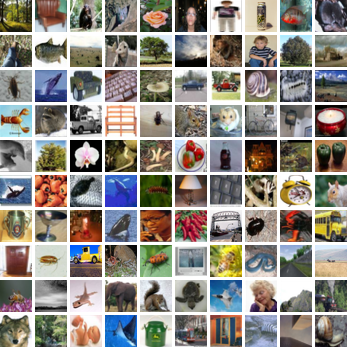

In [ ]:
showimage(testDB,124) # テスト画像の124番目から100枚表示

CIFAR-100 の被写体のカテゴリには、0〜9の大分類番号と0~99の詳細分類番号がつけられています。カテゴリ番号と日本語の意味の対応表を用意しました。　⇒ **taxonomy.txt**

全カテゴリの表を一番下につけてあります。

In [ ]:
#  カテゴリ表の表示
taxonomy = pd.read_csv("taxonomy.txt", header=0)
taxonomy = taxonomy.drop('id',axis=1)
taxonomy.head(10)  # 上から10カテゴリを表示

,ccat,fcat,cword,fword
0,0,4,水生哺乳類,ビーバー
1,0,30,水生哺乳類,イルカ
2,0,55,水生哺乳類,カワウソ
3,0,72,水生哺乳類,アザラシ
4,0,95,水生哺乳類,クジラ
5,1,1,魚,観賞魚
6,1,32,魚,ヒラメ
7,1,67,魚,エイ
8,1,73,魚,サメ
9,1,91,魚,マス


In [ ]:
# 名称からid を調べる
def word2fcat(word):
    return taxonomy[taxonomy['fword']==word]['fcat'].iloc[0]

word2fcat('芝刈り機')

41

100 枚


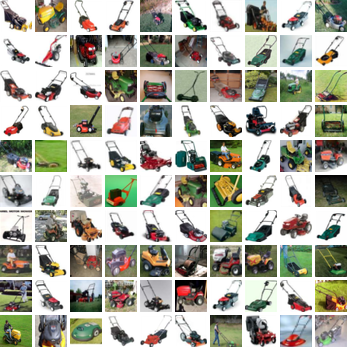

In [ ]:
# CIFER-100のデータ data から、カテゴリ名 cat の画像だけ抽出する  
def getCat(data,cat):
    flabels = data[b'fine_labels']
    images = data[b'data']
    extract = []
    id = word2fcat(cat)
    for fl, img in zip(flabels,images):
        if fl == id :
            extract.append(img)  
    return extract

# 画像を1行に10個ずつ並べた画像を作り、表示する
def showBimages(blobs, start=0, npic=100):  # start番目からnpic枚表示
    dsize = len(blobs)
    limit = start + npic
    if limit > dsize:
        limit = dsize
        npic = limit - start
    rows  =  (npic-1)//10+1
    print(npic,"枚")
    canvas =  Image.new('RGB',(350,35*rows),(255,255,255))
    n = start
    i = 0
    j = 0
    while n < limit:
        canvas.paste(flat2image(blobs[start+i*10+j]),(35*j,35*i))
        j +=1
        if j == 10:
            i, j = i+1,0
        n +=1
    return canvas

# showBimages(getCat(test,'カワウソ'))
# showBimages(getCat(test,'イルカ'))
# showBimages(getCat(test,'クジラ'))

ｓhowBimages(getCat(testDB,'芝刈り機'))

# ３カテゴリー識別問題◯　
<font color=red>(◯付きは読むだけでなく必ず実践してください.)</font>

チューリップ100枚，ヒマワリ100枚,バラ100枚の計300枚を用い、シャッフルして枚数の比を保ったま150枚を訓練に使い，残り150枚に対する認識率を求めてみる．

下では testデータから 150枚抜き出しているが、train からでもいい。
train にはデータが5万枚分もあるので抽出に時間がかかる。

test は１万枚なので train から抜き出すより早いが、各カテゴリ100枚ずつしかない。
つまり、testから特定のカテゴリの画像100枚抜き出すということは全部ぬきだぬきだすことになる.



# 1. 識別対象カテゴリーのデータの抽出◯

In [ ]:
turip = getCat(testDB,'チューリップ')[0:100] #  チューリップの画像100枚の配列
sunflower = getCat(testDB,'ヒマワリ')[0:100] #  ヒマワリの画像100枚の配列
rose = getCat(testDB,'バラ')[0:100] #  バラの画像100枚の配列

100 枚


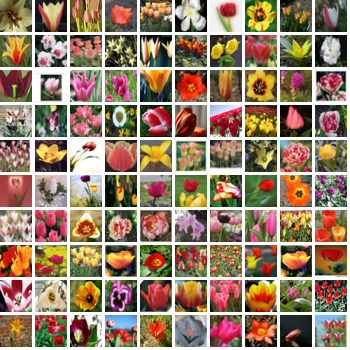

In [ ]:
showBimages(turip) # チューリップを表示

100 枚


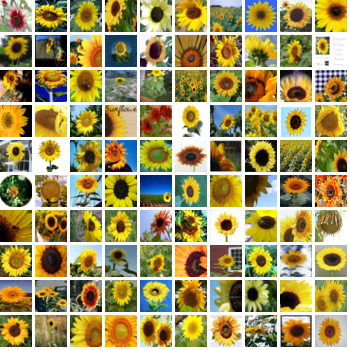

In [ ]:
showBimages(sunflower) # ひまわりを表示

100 枚


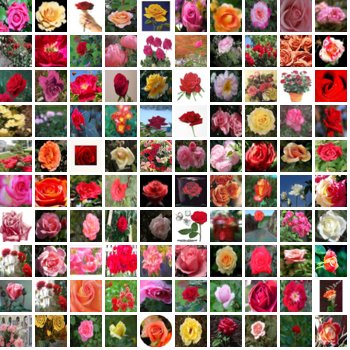

In [ ]:
showBimages(rose) # 薔薇を表示

以上300枚が実験用画像である。
# 2. 学習実験用のデータ作成◯

In [ ]:
from sklearn.preprocessing import StandardScaler # 標準化のライブラリ

baseX = np.array(turip+sunflower+rose) # 3カテゴリのデータをマージ

# ロジスティック回帰とSVMのために標準化データを作る
sc = StandardScaler() # 標準化作用素の生成
std_baseX = sc.fit_transform(baseX) # 標準化の実行

basey = np.array([0]*100+[1]*100+[2]*100).astype(np.int32) # 正解ラベル

300はデータ数、3072は次元数＝32ｘ32ｘ3色

baseX が画像の配列  個々の画像は全データを１列に並べた３０７２次元ベクトルとして表されている
basey がラベル（詳細カテゴリID)の配列

# 3. 識別実験

# 3.1 ロジスティック回帰

In [ ]:
X,y  = std_baseX, basey
from sklearn import linear_model
from sklearn.model_selection import StratifiedShuffleSplit 
clfL = linear_model.LogisticRegression(solver='liblinear',multi_class='auto') # ロジスティック回帰モデルを用いる

#　訓練用とテスト用に半々にシャッフル分割
ss = StratifiedShuffleSplit(n_splits=10, 
                  train_size=0.5, 
                  test_size=0.5)

for train_index, test_index in ss.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clfL.fit(X_train, y_train) # 訓練データを用いて学習（回帰）を実行
    print("{:5.4f}".format(clfL.score(X_test, y_test))) # テスト用画像に対する認識率を表示
    # print(clf.score(X_train, y_train)) # 訓練用画像に対する認識率を表示（通常は１になる。確認したい人は # を外してためしてみよ）

0.5733
0.5533
0.6000
0.6000
0.6333
0.5933
0.5333
0.5467
0.5933
0.6000


上のプログラムでは、300枚の画像をシャッフルしてから半分を訓練用、残り半分をテスト用に分け、訓練用で学習（fit）してからテスト用画像に対する正答率を表示、という操作を10回実行しています。

この識別問題では、ロジスティック回帰では、5~6割の正答率となります。

訓練例画像に対する正答率を出してみたい人は最後の行の＃を外して、行頭をそろえてから実行してみて下さい。1.0（＝100％）となるはずです。

この10回の試行は徐々に学習を進めているのではなく、それぞれ独立した学習なので認識率が上がっていくわけではありません。

# 3.2 線形SVM　サポートベクターマシン

In [ ]:
X,y  = std_baseX, basey
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedShuffleSplit
clfSVM = svm.LinearSVC() # サポートベクターマシン

ss =  StratifiedShuffleSplit(n_splits=10, train_size=0.5, test_size=0.5) # 10分割して

for train_index, test_index in ss.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clfSVM.fit(X_train, y_train)
    print("{:5.4f}".format(clfSVM.score(X_test, y_test))) # 訓練用画像の認識率
    # print(clf.score(X_train, y_train))

0.5933
0.5800
0.5867
0.6000
0.6067
0.5933
0.5200
0.5733
0.5267
0.5600


線形SVMも正答率は５〜６割となります。

線形SVMもロジスティック回帰も、線形識別という点では同じです。SVMの方が巧妙に識別面を設定しているので、ロジスティック回帰よりも正答率は高くなるはずですが、この問題では明白な差は出ません。

# 誤認識画像の確認

先の線形SVMの実験の最後にできた識別器はどんな画像をどう誤認識しているのか確認してみよう。

識別結果
 [1 0 1 0 0 0 2 1 0 0 0 0 0 1 0 0 0 2 0 0 2 0 0 0 2 0 1 1 2 0 0 0 0 1 0 2 0
 0 0 2 0 0 0 0 0 1 0 0 0 1 2 0 0 0 2 0 0 0 1 0 1 0 0 0 0 2 1 1 0 0 0 0 0 0
 2 0 1 2 0 0 2 0 0 2 0 0 0 1 0 0 0 0 1 0 1 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 2 2 2 2 1 2 1 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 0 0 2 2 0 2 0 0 2 2 2 2 2 2 0 2 0 2 0 2 2 0 0 2 0 2 2 2 2
 2 2 0 2 0 2 2 1 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 1 2 0 0 2 2
 2 0 2 2]
誤認識画像 66 枚


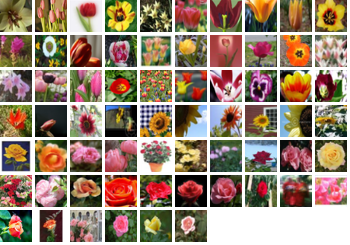

In [ ]:
X,y  = std_baseX, basey
pred = clfSVM.predict(X)
print("識別結果\n",pred)
errimg = []
for i in range(300):
    if pred[i] !=y[i] : # 認識結果 pred[i] と　正解 y[i] が異なる
        errimg.append(baseX[i])
print("誤認識画像",end=' ')
showBimages(errimg,0)


（補足）全部正解ならば、０が100個、１が100個、２が100個それぞれ連続で続く。

# 3.3 CNN ◯
### 準備１　reshape ◯
ここまでは、画像データを1次元的に展開して扱ってきたが、CNN（畳み込みネットワーク） では画像を

　（データ数、チャネル数, 高さ, 幅）<font color=green size=3>（＊）</font>
 
 という形式で表す。そこでまず、reshape する。
 
 ---

<font color=green size=2>　深層学習のフレームワークによって順序は異なる。これは chainer が指定する順序。例えば Googleの提供する Tensolflow では、（データ数、幅、高さ、チャネル数）である。</font>

### 準備２ 平均値を引く ◯
データ全体のRGBそれぞれの平均値を求めて各データから引いて平均が０になるようにする。
必然ではないが、そうした方が一般に収束が早い。

In [ ]:
X, y  = baseX, basey
X_ = X.copy().reshape((300,3,32,32)).astype(np.float32)  # 1次元データを４次元データに変換
mean = np.average(np.average(np.average(X_,axis=0),axis=1),axis=1) # RGB それぞれの平均
print("RGB平均値",mean)
X_[:,0,:,:]=X_[:,0,:,:]-mean[0]
X_[:,1,:,:]=X_[:,1,:,:]-mean[1]
X_[:,2,:,:]=X_[:,2,:,:]-mean[2] 
X_ = X_/127.0  # -1〜+1 で表現
y = y.astype(np.int32)
Pdata = [(x,label) for x,label in zip(X_,y)] # データとラベルのペアデータ
baseX_ = X_ # 分離データ

RGB平均値 [137.78987  110.608955  78.1041  ]


## 準備３ ディープラーニング用のライブラリのインポート◯

In [ ]:
import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer import training
from chainer.datasets import tuple_dataset
from chainer.iterators import SerialIterator
from chainer import training
from chainer.training import trainer, extensions
from chainer.dataset import concat_examples

ModuleNotFoundError: ignored

## 3.3.1 典型的なCNN◯

入力層は　３２×３２×３チャネル
1. ３ｘ３畳み込み　32チャネル 　  -> 32x32x32チャネル
2. max pooling 2x2 -> 16x16x32チャネル
3. ３ｘ３畳み込み　32チャネル　 -> 16x16x32チャネル
4. max pooling 2x2 -> 8x8x32チャネル (計2048ノード）
5. 2048対128の全結合  -> 128ノード 
7. 128対3の全結合 -> 3ノード
8.　Softmax 出力

畳み込み層と全結合層の活性化関数としては ReLU関数を用いる

In [ ]:
class MyNet(chainer.Chain):
    def __init__(self):
        super(MyNet,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3,32,3,1,1)
            self.conv2 = L.Convolution2D(32,32,3,1,1)
            self.l1 = L.Linear(2048,128)
            self.l2 = L.Linear(128,3)

    def __call__(self,x):
        h = Variable(x)
        h = F.relu(self.conv1(h))
        h = F.max_pooling_2d(h,2,2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h,2,2)
        h = F.dropout(F.relu(self.l1(h)))
        if chainer.config.train:
            return self.l2(h)
        return F.softmax(self.l2(h))
    
model = MyNet()
# model = L.Classifier(model)

# 訓練例を準備◯

In [ ]:
'''X, y  = baseX, basey
X_ = X.copy().reshape((300,3,32,32)).astype(np.float32)  # 1次元データを４次元データに変換
mean = np.average(np.average(np.average(X_,axis=0),axis=1),axis=1) # RGB それぞれの平均
print("RGB平均値",mean)
X_[:,0,:,:]=X_[:,0,:,:]-mean[0]
X_[:,1,:,:]=X_[:,1,:,:]-mean[1]
X_[:,2,:,:]=X_[:,2,:,:]-mean[2] 
X_ = X_/127.0  # ほぼ±１の範囲に入る
y = y.astype(np.int32)
Pdata = [(x,label) for x,label in zip(X_,y)] # データとラベルのペアデータ
baseX_ = X_ # 分離データ
'''

In [ ]:
# データをシャッフルして半分をて訓練用、半分をテスト用に分ける
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedShuffleSplit
ss =  StratifiedShuffleSplit(n_splits=1, train_size=0.5, test_size=0.5) 
for g1, g2 in ss.split(Pdata, y):
    train = [Pdata[x] for x in g1]
    test = [Pdata[x] for x in g2]

# 訓練ループの定義◯

In [ ]:
def trainloop(model, max_epoch=10, batchsize =10,traintimes = 0):
    # batchsize = 10  # バッチサイズ　　データセットをこのサイズに分割し、少しずつ学習する
    # max_epoch = 10 #  全訓練データを何回学習するか

    train_iter = SerialIterator(train, batch_size=batchsize, shuffle=True)
    test_iter = SerialIterator(test, batch_size=batchsize,repeat=False, shuffle=False)

    # chainer には典型的な設定で繰り返しトレーニングする trainer という仕組みが用意されている
    # updater = training.StandardUpdater(train_iter, optimizer)
    # trainer = training.Trainer(updater, (2, 'epoch'), out='result')
    # 今回は使わないで自分で定義することにする。

    print('epoc   train_loss      train_accuracy      test_loss      test_accuracy')

    
    train_losses = []
    train_accuracies = []
    rec =[]
    
    while train_iter.epoch < max_epoch:

        #  --  ここから訓練のフェーズ
        train_batch = train_iter.next()  # バッチ単位で例を取り出す
        X, y = concat_examples(train_batch)  # データとラベルに分離
    
        pred = model(X)  # 現時点での出力を求める
        loss = F.softmax_cross_entropy(pred, y)  # 現出力と理想出力の交差エントロピーを計算
        
        train_losses.append(float(loss.data))
        train_accuracies.append(float(F.accuracy(pred, y).data))
    
        model.cleargrads() # 微係数データを初期化
        loss.backward() # 誤差を逆伝搬する。
    
        optimizer.update()  # 　誤差が減るように重みを更新
        #  --  訓練のフェーズここまで
    
        if train_iter.is_new_epoch:   # max_epoch ごとに評価
            traintimes += 1    
            test_losses = []
            test_accuracies = []
            while True:
                test_batch = test_iter.next() # テストデータからバッチ単位分取り出す
                X, y = concat_examples(test_batch)  #データとラベルに分離

                pred = model(X) # 出力を求める
                loss = F.softmax_cross_entropy(pred, y) # 交差エントロピーを計算
                test_losses.append(float(loss.data))

                # 認識率を計算する
                accuracy = F.accuracy(pred, y)
                test_accuracies.append(float(accuracy.data))

                if test_iter.is_new_epoch:
                    test_iter.reset()
                    break
                    
            trm = np.mean(train_losses)
            tra = np.mean(train_accuracies)
            tem = np.mean(test_losses)
            tea = np.mean(test_accuracies)
            print(' {:03d}      {:.04f}           {:.04f}'.format(
                  train_iter.epoch,trm, tra),end="")
            train_loss,  train_accuracies= [], []    
            print('                 {:.04f}          {:.04f}'.format(
                 tem, tea))
            rec.append([train_iter.epoch,trm,tra,tem,tea])
    return rec

# 誤差の総和（loss）と正解率（accuracy）の学習曲線
def showlgraph(rec,showlimit=5):
    df = pd.DataFrame(rec,columns=['epoc','train_loss','train_accuracy','test_loss','test_accuracy'])
    plt.figure(figsize=(10, 10))
    plt.ylim(bottom=0,top=df.max()[1:].max()*1.05)
    plt.plot(df['epoc'],df['train_loss'],label='train_loss')
    plt.plot(df['epoc'],df['test_loss'],label='test_loss')
    plt.plot(df['epoc'],df['train_accuracy'],label='train_accuracy')
    plt.plot(df['epoc'],df['test_accuracy'],label='test_accuracy')
    plt.title("loss & accuracy")
    plt.xlabel("epocs")
    plt.legend() 
    plt.savefig("graph.jpg")

# オプティマイザーを作成し、訓練実行◯

In [ ]:
model = MyNet() # オプティマイザーを変えるなら model を再定義すべき

optimizer = optimizers.Adam()
# optimizer = optimizers.AdaGrad()
# optimizer = optimizers.SGD()
optimizer.setup(model)

rec = trainloop(model = model, max_epoch=10, batchsize =10,traintimes = 0)
showlgraph(rec)

訓練データの accuracy （正答率）がほぼ１になるのは当然で、大事なのはtest データの方の正答率（testacc)です。選ばれたデータと乱数次第で、だいたい６〜７割の正答率が出ます

このネットワークはあまり深くはありませんが、中間層が３つ（畳み込み層が２つと全結合層が１つ。プーリング層２つも数えるなら、５つ）あるので深層学習に属します。

結果からわかるように、深層学習を用いたからといって認識率が上がるとは限りません。全結合層のノードを1024等に増やしても、この構成ではさほど改善は見られません。（興味のある人はいろいろ試してみてください。もしよい結果が得られたら教えてください。）

# 誤り事例を表示

In [ ]:
predall  = np.argmax(model(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
print("誤認識画像",end=' ')
showBimages(errimg,0)

# 3.3.2 ３層バックプロパゲーションネット

単純な中間層１つのネットワークで、誤差逆伝搬学習を試みてみます。

中間層は16としてみます。

In [ ]:
class MyNet2(chainer.Chain):
    def __init__(self):
        super(MyNet2,self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(3072,16)
            self.l3 = L.Linear(16,3)            

    def __call__(self,x):
        h = Variable(x)
        h = F.relu(self.l1(h))
        if chainer.config.train:
            return self.l3(h)
        return F.softmax(self.l3(h))

In [ ]:
model2 = MyNet2()

optimizer = optimizers.Adam()
# optimizer = optimizers.AdaGrad()
# optimizer = optimizers.SGD()

optimizer.setup(model2)

rec =trainloop(model = model2, max_epoch=10, batchsize =10,traintimes = 0)
showlgraph(rec)

ノード数が中間層１６と少なく設定してあるので、学習は短時間で済みます。５割前半〜運が良ければ７割弱程度の正答率が出ることもあります。

In [ ]:
predall  = np.argmax(model2(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
print("誤認識画像",end=' ')
showBimages(errimg,0)

中間層がたったの16ノードの三層ニューラルネットでもあまり認識率に変わりがなかった

[Batch Normalization：ニューラルネットワークの学習を加速させる汎用的で強力な手法](https://deepage.net/deep_learning/2016/10/26/batch_normalization.html)

# 3.3.3 よりディープなCNN
畳み込み(32ch)　⇒　畳み込み(32ch)　⇒　プーリング　⇒　畳み込み(32ch)　　⇒　プーリング　⇒　畳み込み(32ch)　⇒　全結合(64ch) ⇒　全結合(32ch) ⇒　softmax(3ch)

（注）このモデルはメモリの少ない環境ではメモリ不足になる可能性があります。

In [ ]:
class MyNet3(chainer.Chain):
    def __init__(self):
        super(MyNet3,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3,32,3,1,1)
            self.conv2 = L.Convolution2D(32,32,3,1,1)
            self.bnorm1 = L.BatchNormalization(32)
            self.conv3 = L.Convolution2D(32,32,3,1,1)
            self.conv4 = L.Convolution2D(32,32,3,1,1)
            self.l1 = L.Linear(2048,64)
            self.l2 = L.Linear(64,32)
            self.l3 = L.Linear(32,3)

    def __call__(self,x):
        h = Variable(x)
        h = F.relu(self.conv1(h))
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h,2,2)
        h = self.bnorm1(h)
        h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(h,2,2)
        h = F.relu(self.conv4(h))
        h = F.dropout(F.relu(self.l1(h)))
        h = F.dropout(F.relu(self.l2(h)))
        if chainer.config.train:
            return self.l3(h)
        return F.softmax(self.l3(h))
    
model = MyNet3()
# model = L.Classifier(model)

In [ ]:
model3 = MyNet3()

optimizer = optimizers.Adam(0.001)
# optimizer = optimizers.AdaGrad()
# optimizer = optimizers.SGD()

optimizer.setup(model3)

rec = trainloop(model = model3, max_epoch=20, batchsize =50,traintimes = 0)
showlgraph(rec)

ディープなので時間がかかります。その割にはそれほどパフォーマンスが上がりません。
深くなるほどパラメータが増えるのでチューニングが非常に難しいです。

それでもこれほど深くても学習が進むようになったのは最近の研究成果の賜物なのです。

In [ ]:
# 誤りデータの確認
predall  = np.argmax(model3(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
print("誤認識画像",end=' ')
showBimages(errimg,0)

ネットが深くて時間がかかる割に結果はぱっとしない

# 3.3.4 全結合層がないとどうなるか

畳み込み(16ch)　⇒　畳み込み(32ch)　⇒　プーリング　⇒　畳み込み(32ch)　　⇒　プーリング　⇒　畳み込み(16ch)　⇒　softmax(3ch)


In [ ]:
class MyNet4(chainer.Chain):
    def __init__(self):
        super(MyNet4,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3,16,3,1,1)
            self.conv2 = L.Convolution2D(16,32,3,1,1)
            self.bnorm1 = L.BatchNormalization(32)
            self.conv3 = L.Convolution2D(32,32,3,1,1)
            self.conv4 = L.Convolution2D(32,16,3,1,1)
            self.l3 = L.Linear(1024,3)

    def __call__(self,x):
        h = Variable(x)
        h = F.relu(self.conv1(h))
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h,2,2)
        h = self.bnorm1(h)
        h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(h,2,2)
        h = F.relu(self.conv4(h))
        if chainer.config.train:
            return self.l3(h)
        return F.softmax(self.l3(h))


In [ ]:
model4 = MyNet4()

optimizer = optimizers.Adam(0.001)  # 学習係数 0.001 がデフォルト
# optimizer = optimizers.AdaGrad()
# optimizer = optimizers.SGD()

optimizer.setup(model4)

rec = trainloop(model = model4,max_epoch=20, batchsize =50,traintimes = 0)
showlgraph(rec)


(結果）

意外なことに、わりと安定したパフォーマンスが得られます。良い学習セットに当たればテストデータの正解率（test_accuracy）が７０％を超えます。

In [ ]:
# 誤りデータの確認
predall  = np.argmax(model4(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
print("誤認識画像",end=' ')
showBimages(errimg,0)

---

??? 正解率が高かったのに正解率が低かった場合より誤り画像の数が多くて、「あれっ？」と思うことがありますが、それは正解率はテスト画像セットに対する値で、ここで表示している誤り画像は訓練画像とテスト画像を合わせた場合の誤りだからです。

テスト画像に対する正答率は高いが、訓練画像で誤ってしまうという場合があるわけです。

# <font color=red>☆☆☆☆</font>

# ４．別のデータセットでの検証

最後に、train （訓練用）50000枚中のチューリップ、ヒマワリ、バラの画像 各 500枚合計1500枚で認識率を出してみよう。

In [ ]:
turip2 = getCat(trainDB,'チューリップ')
sunflower2 = getCat(trainDB,'ヒマワリ')
rose2 = getCat(trainDB,'バラ')
X2 = np.array(turip2+sunflower2+rose2)
y2 = np.array([0]*500+[1]*500+[2]*500).astype(np.int32) # 正解ラベル

X2_ = X2.copy().reshape((1500,3,32,32)).astype(np.float32)
# mean = np.average(np.average(np.average(X2_,axis=0),axis=1),axis=1) # RGB それぞれの平均

X2_[:,0,:,:]=X2_[:,0,:,:]-mean[0]
X2_[:,1,:,:]=X2_[:,1,:,:]-mean[1]
X2_[:,2,:,:]=X2_[:,2,:,:]-mean[2]   # mean は学習用のものを使う
X2_ = X2_/127.0  # -1〜+1 で表現
predall2 = []
for i in range(0,1500,100): # メモリ不足対策のために100画像ずつ認識
    predall2=np.r_[predall2,np.argmax(model4(X2_[i:i+100]).data,axis=1)]

In [ ]:
s1,s2,s3 = 0,0,0

for i in range(500):
    if predall2[i] == 0:
        s1 += 1
    if predall2[500+i] == 1:
        s2 += 1
    if predall2[1000+i] == 2:
        s3 += 1

print("チューリップの正解は {} 枚 正解率 {}%".format(s1, np.round(s1/5,2)))
print("ヒマワリの正解は {} 枚 正解率 {}%".format(s2, np.round(s2/5,2)))
print("バラの正解は {} 枚 正解率 {}%".format(s3, np.round(s3/5,2)))

cs = s1+s2+s3
es = 1500 - cs
print("全枚数 {} 枚中、正解 {} 枚、不正解{}枚、正解率{}%".format(1500, cs,es,np.round(cs/15,2)) )
'''errimg2 = []
for i in range(1500):
    if predall2[i] !=y2[i] :
        errimg2.append(X2[i])
showBimages(errimg2,0,len(errimg2))''';

# 考察（の例）

学習した枚数が各カテゴリ50枚ずつ計150枚で、学習対象外のデータ1500枚に対する正答率〇〇％が学習時に用いたテストデータ150枚に対する正答率〇〇とほぼ同じであった。

これは、データである画像に統計的な偏りがなかったということと、それを前提として150枚のサンプル調査で全体のパフォーマンスがだいたい予想できているということを意味する。

カテゴリ別の正解率を比べると、ヒマワリは正解率が〇〇％を超えて好成績であるのに対して、チューリップとバラの正解率は〇〇％程度と低い値となっている。ヒマワリの正答率が高い理由としては、バラとチューリップの花は色が多様であるのに対し、ヒマワリの花は色の幅が狭いということが効いているのであろう推測される。

--

今回はたったの3カテゴリなのにこんなに低い正解率でしたが、CIFAR-100の識別問題は結構難しく、下記の [What is the class of this image ?](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)にによれば、世界最高で75％程度の認識率です。もっともそれは100カテゴリでの数字ですが。

# <font color=red> 課題 </font>
1. まず、ここまでのプログラムを上から順に実行し、少なくとも、「☆☆☆☆」までは SHIFT+ENTER で実行し、内容を理解する。
2. 内容を理解したら、下のプログラムの「赤ちゃん」「山」「バス」の部分を別のカテゴリに置き換えて実行し、結果と考察をレポートにまとめて報告する。正答率は表にするなどして読者に分かり易くする工夫をすること。

## 考察すべき事項
1. 分類対象カテゴリ　　　認識精度の高い組わせと低い組合せ、なぜそうなのか
2. 識別モデル  myNet, myNet2, myNet3, myNet4 、その他
3. どのオプティマイザーがよいか

表、グラフ、図を貼っただけのものはレポートではありません。
課題内容や手順、考察をきちんとした文章を記載すること。

また、理解できない言葉や概念は調べること。

### 註１　このプログラム中で定義したニューラルネットネットワーク
- myNet -- 典型的なCNN（たたみ込みニューラルネット）
- myNet2 -- ３層バックプロパゲーションネット
- myNet3 -- よりディープなCNN
- myNet4 -- 全結合層なしのCNN
myNet2～myNet4 は☆より後にあることに注意。利用する場合は該当するモデル定義のプログラムを先に実行しなければならない。

### 註２　オプティマイザー

> optimizers.Adam()  
> optimizers.AdaGrad()  
> optimizers.SGD()  

以上三種が使える。

各モデル定義のプログラムの部分に、

<pre>
optimizer = optimizers.Adam()  
# optimizer = optimizers.AdaGrad()
# optimizer = optimizers.SGD()
</pre>

という文がある。使わないオプティマイザーの行の先頭に＃を入れ、使いたいオプティマイザーの先頭の＃を削除して左詰にしてから、実行しなおす。



# 実験用のプログラム
## 1. 実験用データの作成

In [ ]:


catname1,catname2,catname3 = '赤ちゃん','山','バス' # ←できて当然であまりよろしくない例

cat1 = getCat(testDB,catname1) # catname1 の画像データを抽出
cat2 = getCat(testDB,catname2) # catname２ の画像データを抽出
cat3 = getCat(testDB,catname3) # catname３ の画像データを抽出

X3 = np.array(cat1+cat2+cat3)
y3 = np.array([0]*100+[1]*100+[2]*100).astype(np.int32) # 正解ラベル

X3_ = X3.copy().reshape((300,3,32,32)).astype(np.float32) # ４次元データ化
mean3 = np.average(np.average(np.average(X3_,axis=0),axis=1),axis=1) # RGB それぞれの平均
print("RGB平均値",mean3)

X3_[:,0,:,:]=X3_[:,0,:,:]-mean3[0] # 各データから RGB の平均値を引く。
X3_[:,1,:,:]=X3_[:,1,:,:]-mean3[1]
X3_[:,2,:,:]=X3_[:,2,:,:]-mean3[2]   
X3_ = X3_/127.0  # -1〜+1 の表現に変換

Pdata3 = [(x,label) for x,label in zip(X3_,y3)] # データとラベルのペアデータ

In [ ]:
# データをシャッフルして半分をて訓練用、半分をテスト用に分ける
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedShuffleSplit
ss =  StratifiedShuffleSplit(n_splits=5, train_size=0.5, test_size=0.5) 
for g1, g2 in ss.split(Pdata3, y3):
    train = [Pdata3[x] for x in g1]
    test = [Pdata3[x] for x in g2]

## ２．学習

In [ ]:
model = MyNet() # <= 識別モデル　MyNet, MyNet2,MyNet3,MyNet4 をそれぞれ試す

# 一番最初の CNN のモデルで　２５エポック（エポックとは全学習データを一通り１度学習すること）
# 学習は １度に50 画像分ずつ学習。

optimizer = optimizers.Adam(alpha=0.0005, beta1=0.9, beta2=0.999, eps=1e-08)  # 学
# optimizer = optimizers.SGD(lr=0.01)
# optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)
# optimizer = optimizers.RMSpropGraves(lr=0.0001, alpha=0.95, momentum=0.9, eps=0.0001)
# optimizer = optimizers.AdaDelta(rho=0.95, eps=1e-06)
optimizer.setup(model)
rec = trainloop(model = model, max_epoch=20, batchsize =10,traintimes = 0)
showlgraph(rec)

**train loss** 訓練用画像の識別誤差  
**train accuracy** 訓練用画像に対する正答率  
**test loss** テスト用画像（未知画像）の識別誤差  
**test  accuracy** テスト用画像（未知画像）に対する正答率  

---


## 3. 誤認識された画像の確認
理由や傾向を考察しよう

In [ ]:
predall  = np.argmax(model(X3_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(X3[i])

s1,s2,s3 = 0,0,0
for i in range(100):
    if predall[i] != 0:
        s1 += 1
    if predall[100+i] != 1:
        s2 += 1
    if predall[200+i] != 2:
        s3 += 1

print("{}の誤認識は {} 枚 正解率 {}%".format(catname1,s1, 100-s1))
print("{}の誤認識は {} 枚 正解率 {}%".format(catname2,s2, 100-s2))
print("{}の誤認識は {} 枚 正解率 {}%".format(catname3,s3, 100-s3))
es = s1+s2+s3
cs = 300 - es
print("全枚数 {} 枚中、正解 {} 枚、不正解{}枚、正解率{}%".format(300, cs,es,np.round(cs/3,2)) )
print("誤認識した画像は計",end=" ")
showBimages(errimg,0)


# お疲れ様でした


# 参考文献など

実装に関して参考にしたサイト
- [chainer tutorial](https://docs.chainer.org/en/latest/tutorial/train_loop.html)
- [CIFAR-10, CIFAR-100のデータを読み込む方法](http://qiita.com/supersaiakujin/items/5e9d2b2850e256f99982)

CNNの分かりやすい解説
- [定番のConvolutional Neural Networkをゼロから理解する](https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html)
- [Optimizer についての解説](http://qiita.com/tokkuman/items/1944c00415d129ca0ee9)

chainer には CIFAR-10, CIFAR-100のデータを読み込むためのメソッドが用意されているのでそれを使えば一発なのですが、今回はそれを使っていません。

さまざまな認識課題とそのチャレンジ状況をまとめてくれているサイト

- [What is the class of this image ?](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

- [カテゴリー別アーカイブ: CIFAR-100](http://tensorflow.classcat.com/category/cifar-100/)
-- [TensorFlow の各種ドキュメントの翻訳 | TensorFlow の簡単な応用例](http://tensorflow.classcat.com/)

# 付録

# CIFER-100　のカテゴリ分類
|||
|:--|:--|
|スーパークラス|クラス|
|海洋哺乳類|ビーバー, イルカ, カワウソ, アザラシ, クジラ|
|魚類|観賞魚, ヒラメ, エイ, サメ, マス|
|花|ラン, ポピー, バラ, ヒマワリ, チューリップ|
|食品|ボトル, ボウル, カン, カップ, プレート|
|果物と野菜|リンゴ, キノコ, オレンジ, ナシ, ピーマン|
|家電|時計, キーボード, ランプ, 電話, テレビ|
|家具|ベッド, 椅子, ソファー, テーブル, タンス|
|昆虫|蜂, 甲虫, 蝶, いも虫, ゴキブリ|
|大型肉食獣|クマ, ヒョウ, ライオン, トラ,オオカミ|
|屋外の大型建造物|橋, 城, 家, 道, 超高層ビル|
|自然シーン|雲, 森, 山, 平原, 海|
|草食または雑食の動物|ラクダ, ウシ, チンパンジー, ゾウ, カンガルー|
|中型哺乳類|キツネ, ヤマアラシ, フクロネズミ, アライグマ, スカンク|
|無脊椎動物（昆虫は除く）|カニ, ロブスター, カタツムリ, クモ, ミミズ|
|人|赤ちゃん, 男の子, 女の子, 男性, 女性|
|爬虫類|ワニ, 恐竜, トカゲ, ヘビ, カメ|
|小型哺乳類|ハムスター, マウス, ウサギ, トガリネズミ, リス|
|木|カエデ, カシ, ヤシ, マツ,ヤナギ|
|乗り物 1|自転車, バス, オートバイ, ピックアップトラック, 電車|
|乗り物 2|芝刈り機, ロケット, 路面電車, タンク, トラクタ|
 

### taxonomy.txt

以下が、プログラム中で読み込んでいるカテゴリ表（taxonomy.txt）の内容です。メモ帳等にコピペして taxonomy.txt というファイル名でこのプログラムと同じフォルダに保存して下さい。

---

```
id,ccat,fcat,cword,fword
0,0,4,水生哺乳類,ビーバー
1,0,30,水生哺乳類,イルカ
2,0,55,水生哺乳類,カワウソ
3,0,72,水生哺乳類,アザラシ
4,0,95,水生哺乳類,クジラ
5,1,1,魚,観賞魚
6,1,32,魚,ヒラメ
7,1,67,魚,エイ
8,1,73,魚,サメ
9,1,91,魚,マス
10,2,54,花,ラン
11,2,62,花,ポピー
12,2,70,花,バラ
13,2,82,花,ヒマワリ
14,2,92,花,チューリップ
15,3,9,食器,ボトル
16,3,10,食器,ボウル
17,3,16,食器,缶
18,3,28,食器,カップ
19,3,61,食器,プレート
20,4,0,果物と野菜,リンゴ
21,4,51,果物と野菜,キノコ
22,4,53,果物と野菜,オレンジ
23,4,57,果物と野菜,ナシ
24,4,83,果物と野菜,ピーマン
25,5,22,家電,時計
26,5,39,家電,キーボード
27,5,40,家電,ランプ
28,5,86,家電,電話
29,5,87,家電,テレビ
30,6,5,家具,ベッド
31,6,20,家具,椅子
32,6,25,家具,ソファー
33,6,84,家具,テーブル
34,6,94,家具,タンス
35,7,6,昆虫,蜂
36,7,7,昆虫,甲虫
37,7,14,昆虫,蝶
38,7,18,昆虫,いも虫
39,7,24,昆虫,ゴキブリ
40,8,3,大型肉食獣,クマ
41,8,42,大型肉食獣,ヒョウ
42,8,43,大型肉食獣,ライオン
43,8,88,大型肉食獣,トラ
44,8,97,大型肉食獣,オオカミ
45,9,12,屋外の大型建造物,橋
46,9,17,屋外の大型建造物,城
47,9,37,屋外の大型建造物,家
48,9,68,屋外の大型建造物,道路
49,9,76,屋外の大型建造物,超高層ビル
50,10,23,自然シーン,雲
51,10,33,自然シーン,森林
52,10,49,自然シーン,山
53,10,60,自然シーン,平原
54,10,71,自然シーン,海
55,11,15,草食または雑食の動物,ヒツジ
56,11,19,草食または雑食の動物,ウシ
57,11,21,草食または雑食の動物,チンパンジー
58,11,31,草食または雑食の動物,ゾウ
59,11,38,草食または雑食の動物,カンガルー
60,12,34,中型哺乳類,キツネ
61,12,63,中型哺乳類,ヤマアラシ
62,12,64,中型哺乳類,フクロネズミ
63,12,66,中型哺乳類,ラクーン
64,12,75,中型哺乳類,スカンク
65,13,26,無脊椎動物（昆虫は除く）,カニ
66,13,45,無脊椎動物（昆虫は除く）,ロブスター
67,13,77,無脊椎動物（昆虫は除く）,カタツムリ
68,13,79,無脊椎動物（昆虫は除く）,クモ
69,13,99,無脊椎動物（昆虫は除く）,ミミズ
70,14,2,人,赤ちゃん
71,14,11,人,男の子
72,14,35,人,女の子
73,14,46,人,男性
74,14,98,人,女性
75,15,27,爬虫類,クロコダイル
76,15,29,爬虫類,恐竜
77,15,44,爬虫類,トカゲ
78,15,78,爬虫類,ヘビ
79,15,93,爬虫類,カメ
80,16,36,小型哺乳類,ハムスター
81,16,50,小型哺乳類,マウス
82,16,65,小型哺乳類,ウサギ
83,16,74,小型哺乳類,トガリネズミ
84,16,80,小型哺乳類,リス
85,17,47,木,カエデ
86,17,52,木,カシ
87,17,56,木,ヤシ
88,17,59,木,マツ
89,17,96,木,ヤナギ
90,18,8,乗り物1,自転車
91,18,13,乗り物1,バス
92,18,48,乗り物1,オートバイ
93,18,58,乗り物1,ピックアップトラック
94,18,90,乗り物1,列車
95,19,41,乗り物2,芝刈り機
96,19,69,乗り物2,ロケット
97,19,81,乗り物2,路面電車
98,19,85,乗り物2,タンク
99,19,89,乗り物2,トラクター
```
---
